In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

In [3]:
def plot_class_distribution(df, column_name, title='Distribuzione delle Classi', color='navy', ax=None):
    # Impostazioni estetiche per il grafico
    sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

    # Creazione del grafico
    if ax is None:
        ax = plt.gca()  # Se non viene passato un asse, usa quello corrente
    sns.countplot(x=column_name, data=df, color=color, ax=ax)  # Imposta un colore uniforme per le barre

    # Titolo e etichette
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Classi', fontsize=14)
    ax.set_ylabel('Numero di Occorrenze', fontsize=14)

    # Aggiungere il numero sopra ogni barra con lo stesso colore della barra
    for p in ax.patches:
        height = int(p.get_height())  # Otteniamo l'altezza della barra
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, 
                    color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                    xytext=(0, 5), textcoords='offset points')

In [4]:
# Caricamento Dataset
data = pd.read_csv("/Users/diego/Desktop/dataset_ottimizzato.csv")

In [5]:
data.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [6]:
# Split the data into features and labels
X = data['text']
y = data['Class']

In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

svd = TruncatedSVD(n_components=100, random_state=42)  # Ad esempio, 100 componenti principali
X_svd = svd.fit_transform(X_tfidf)

# 3. Calcolare la distribuzione totale necessaria per il bilanciamento
# Obiettivo: il 20% del dataset deve avere questa distribuzione nel set di test
desired_test_support = {
    1: 113,
    2: 91,
    3: 60,
    4: 137,
    5: 90,
    6: 110,
    7: 140,
    8: 40,
    9: 50
}

# La somma totale del set di test
test_total = sum(desired_test_support.values())  # 781

# Moltiplichiamo per 5 per ottenere il dataset completo (80% + 20%)
total_needed = test_total * 5  # 781 * 5 = 3905

# 4. Calcolare il numero di esempi per ciascuna classe nel dataset completo
total_per_class = {k: int(v * 5) for k, v in desired_test_support.items()}  # Moltiplichiamo per 5

# 5. Sovracampionamento o sottocampionamento per ottenere il numero di esempi corretto nel dataset completo
smote = SMOTE(sampling_strategy={8: total_per_class[8], 9: total_per_class[9], 3: total_per_class[3], 5: total_per_class[5], 6: total_per_class[6]}, random_state=42)  # Sovracampionamento per classi 3, 5, 6, 8, 9
under_sampler = RandomUnderSampler(sampling_strategy={7: total_per_class[7], 4: total_per_class[4]}, random_state=42)  # Sottocampionamento per classi 7 e 4

# Applicare SMOTE e undersampling sul dataset completo (X_tfidf, y)
X_res, y_res = smote.fit_resample(X_svd, y)  # Sovracampionamento
X_res, y_res = under_sampler.fit_resample(X_res, y_res)  # Sottocampionamento

print("Distribuzione finale del set:", Counter(y_res))


Distribuzione finale del set: Counter({7: 700, 4: 685, 1: 566, 6: 550, 2: 452, 5: 450, 3: 300, 9: 250, 8: 200})


In [8]:

# 6. Dividere il dataset bilanciato in training e test set (80-20), stratificando per mantenere la distribuzione delle classi
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

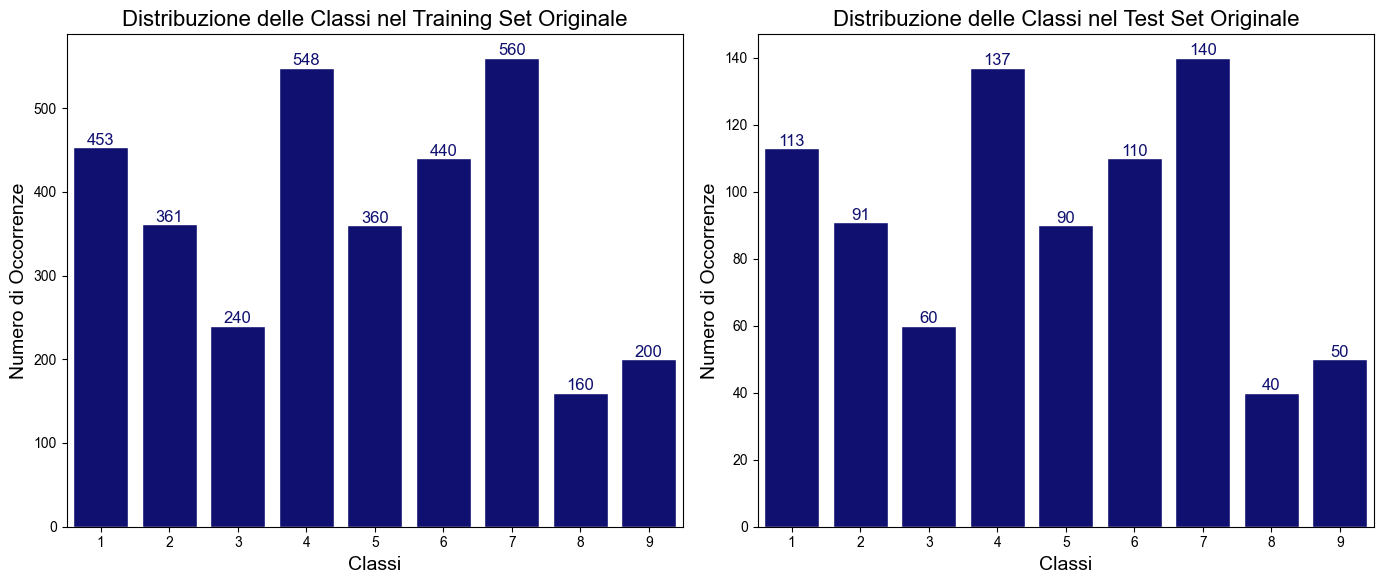

In [9]:
# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il training set
plot_class_distribution(df=pd.DataFrame({'Class': y_train}), column_name='Class', title='Distribuzione delle Classi nel Training Set Originale', color='navy', ax=axes[0])

# Grafico per il test set
plot_class_distribution(df=pd.DataFrame({'Class': y_test}), column_name='Class', title='Distribuzione delle Classi nel Test Set Originale', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# 1. Definizione del modello Random Forest
rf = RandomForestClassifier(random_state=42)

# 2. Definizione della griglia di iperparametri da ottimizzare
param_grid = {
    'n_estimators': [200, 300],  # Numero di alberi
    'max_depth': [None, 20, 30],  # Profondità massima
}

# 3. Configurazione di StratifiedKFold per la validazione incrociata
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. GridSearchCV per ottimizzazione dei parametri con F1-score come metrica
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',  # F1-score pesato per bilanciare le classi
    n_jobs=-1,
    verbose=2
)

# 5. Addestramento del modello sul set di training bilanciato
grid_search.fit(X_train, y_train)

# 6. Recupero del miglior modello
best_rf = grid_search.best_estimator_
print(f"Migliori parametri trovati: {grid_search.best_params_}")

# 7. Previsione sul set di test
y_pred = best_rf.predict(X_test)

# 8. Calcolo delle metriche di valutazione
report = classification_report(y_test, y_pred, target_names=[f"Classe {cls}" for cls in set(y_test)])
accuracy = accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Stampa delle metriche
print("\nReport di classificazione:\n", report)
print(f"Accuracy complessiva: {accuracy:.4f}")
print(f"F1-score medio pesato: {f1_weighted:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Migliori parametri trovati: {'max_depth': 30, 'n_estimators': 200}

Report di classificazione:
               precision    recall  f1-score   support

    Classe 1       0.57      0.57      0.57       113
    Classe 2       0.61      0.58      0.60        91
    Classe 3       0.75      0.73      0.74        60
    Classe 4       0.67      0.69      0.68       137
    Classe 5       0.62      0.63      0.63        90
    Classe 6       0.89      0.82      0.85       110
    Classe 7       0.65      0.69      0.67       140
    Classe 8       0.90      0.93      0.91        40
    Classe 9       1.00      0.98      0.99        50

    accuracy                           0.70       831
   macro avg       0.74      0.74      0.74       831
weighted avg       0.71      0.70      0.70       831

Accuracy complessiva: 0.7040
F1-score medio pesato: 0.7048


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy')

print(f'Cross-Validation Accuracy: {np.mean(cross_val_scores) * 100:.2f}%')


Cross-Validation Accuracy: 69.78%
[CV] END ...................max_depth=None, n_estimators=200; total time=   4.3s
[CV] END ...................max_depth=None, n_estimators=300; total time=   6.6s
[CV] END .....................max_depth=20, n_estimators=300; total time=   6.9s
[CV] END ...................max_depth=None, n_estimators=300; total time=   6.6s
[CV] END .....................max_depth=20, n_estimators=300; total time=   6.4s
[CV] END .....................max_depth=30, n_estimators=200; total time=   4.8s
[CV] END ...................max_depth=None, n_estimators=300; total time=   6.5s
[CV] END .....................max_depth=20, n_estimators=200; total time=   4.5s
[CV] END .....................max_depth=30, n_estimators=200; total time=   4.5s
[CV] END .....................max_depth=30, n_estimators=200; total time=   4.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=   4.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=  